# Gaussian Processes for Orientation Preference Maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import filters

from opm import make_opm, plot_opm, plot_amplitude_map, get_indices
from pinwheels import plot_pinwheels
from response import response, create_stimuli, compute_responses
from kernels import mexican_hat_kernel
from linalg import ridge_cholesky, ICD

## Ground truth map

For computational simplicity, we create an OPM of lower dimensionality. Additionally, we need the (x,y) indices for every pixel.

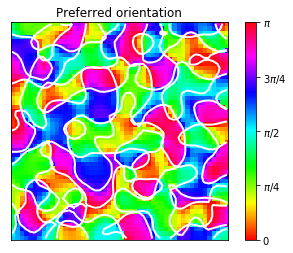

In [2]:
size = 50

n = size**2
d = 3

# ground truth opm
m = make_opm(size=size, sigma=2., k=2.)

f, ax = plot_opm(m)
plot_pinwheels(m, ax)

plt.show()

idx = get_indices(size)

## Responses
The responses are computed exactly the same way as before.

In [3]:
# compute responses
contrasts = [1.0, 1.0, 1.0]
orientations = [i * np.pi / 8 - np.pi/2 for i in range(8)]
repetitions = 8

V = create_stimuli(contrasts, orientations, repetitions)
R = compute_responses(m, contrasts, orientations, repetitions, sigma=0.01)

## Prior covariance
For the prior covariance, a Mexican hat kernel (approximated by a difference of Gaussians) is used:

$$
K_{prior}(x, x') = \sum_{a,b=1}^{2} \frac{\alpha_a \alpha_b}{2 \pi (\alpha_a^2 + \alpha_b^2}) \, exp(-\frac{1}{2} (\frac{||x - x'||^2}{\alpha_a^2 + \alpha_b^2}))
$$

The kernel has three parameters:
- $\sigma$, the standard deviation of the positive Gaussian ($\sigma_1$)
- $k$, the scaling factor for the standard deviation of the negative Gaussian w.r.t. that of the positive Gaussian ($\frac{\sigma_2}{\sigma_1}$)
- $\alpha$, an overall scaling factor ($\alpha_1 = -\alpha_2$)



Here, this kernel function is visualized for the one-dimensional case with two different parameter settings.

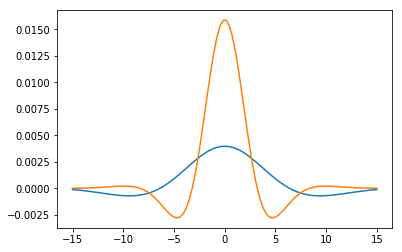

In [4]:
xx = np.linspace(-15, 15, 100)[:,np.newaxis]
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=2.))
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=0.5))
plt.show()

The prior covariance matrix for a set of indices is now computed as the kernel function between every combination of indices.

In [5]:
def prior_covariance(idx, kernel, **kwargs):
    """ Compute the prior covariance matrix for an OPM, given a kernel function
    Args:
        idx: The indices at which to compute the covariance (npixels x 2 matrix, where the kth column contains the x and y coordinates of the kth pixel)
        kernel: a kernel function that takes two vectors x and y
        kwargs: parameters for the kernel function
        
    Returns:
        a matrix of dimensionality npixels x npixels
    """
    
    K = np.zeros((idx.shape[0], idx.shape[0]))
    for i in range(idx.shape[0]):
        for j in range(idx.shape[0]):
            K[i, j] = kernel(idx[i], idx[j], **kwargs)
            
    return K

The spectrum of eigenvalues of $K$ quickly drops off. There are however some negative eigenvalues, since $K$ is not positive definite

In [6]:
K = prior_covariance(idx, kernel=mexican_hat_kernel, sigma=2.)


eigvals = np.linalg.eigvalsh(K)

plt.plot(eigvals[::-1])
plt.show()

KeyboardInterrupt: 

In [22]:
# add a small constant to the diagonal for numerical stability
# this makes the prior covariance positive definite

L = ridge_cholesky(K)

np.allclose(K, L @ L.T)

True

In [23]:
np.linalg.norm(L @ L.T - K)

4.4762327741646594e-07

In [7]:
icd = ICD(rank=500)
icd.fit(idx, mexican_hat_kernel, sigma=2.)

array([[ 9.46222003e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.52122785e-02,  1.46487439e-09,  5.43359798e-10, ...,
         4.39715763e-07, -5.14888911e-08, -5.07989835e-06],
       [ 6.09272640e-02,  5.42966354e-09,  1.43595499e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.74096008e-33,  1.91002619e-19,  5.62051303e-11, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.21222017e-34,  1.25262576e-19,  2.10024470e-11, ...,
        -2.05184006e-05, -4.39640153e-07, -1.39248678e-06],
       [ 1.36464367e-34,  7.96217374e-20,  7.60660772e-12, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [8]:
G = icd.G
#np.allclose(G @ G.T, K, atol=1e-4)

In [26]:
np.linalg.norm(G @ G.T - K)

0.00277942313461115

Since the map components are assumed to be independent, the prior covariance is the same for all components and can be computed as 

$K_m = \mathbb{I}_d \otimes K$

In [10]:
# TODO: add "proper" ridge

K_m = np.kron(np.eye(d), G @ G.T + np.eye(n) * 0.001)

## Noise covariance
We assume for now (for simplicity) that the noise covariance is known and the noise is i.i.d. and Gaussian with variance $\sigma_{\epsilon}$:

$\Sigma_{\epsilon} = \sigma_{\epsilon}\mathbb{I}_n$

In [11]:
# assume that the noise covariance is know (iid Gaussian noise)
sigma_e = 0.1
K_e = np.eye(n) * sigma_e

## Gaussian Process Posterior

The covariance and mean of the Gaussian process can be obtained as:

$ \Sigma_{post}^{-1} = K_m^{-1} + (\sum_i v_i v_i^T) \otimes \Sigma_{\epsilon}^{-1}$

$ \mu_{post} = \Sigma_{post} (\mathbb{I}_d \otimes \Sigma_{\epsilon}^{-1}) \sum_i v_i \otimes \mathbf{r}_i $

In [12]:
# posterior covariance

# TODO: implement more efficient version that does not need to invert the full prior covariance
# and makes use of the ICD
K_post = np.linalg.inv(np.linalg.inv(K_m) + np.kron(V.T @ V, K_e))

In [13]:

vr = np.zeros((n*d,1))
for v, r in zip(V, R):
    vr += np.kron(v, r)[:,np.newaxis]
    
mu_post = K_post @ np.kron(np.eye(d), np.linalg.inv(K_e)) @ vr

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6101c8710>)

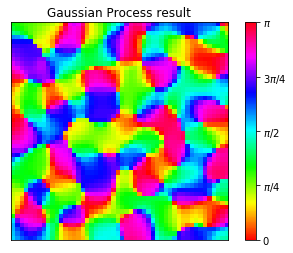

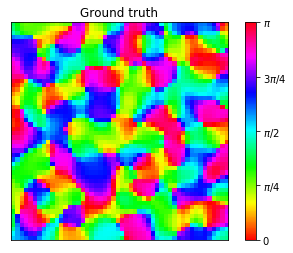

In [14]:
mu = mu_post.reshape(d, size, size)
result = mu[0] + 1j * mu[1]
plot_opm(result, title='Gaussian Process result')

plot_opm(m, title='Ground truth')